In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras import ops

2024-06-25 10:23:23.754282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 10:23:23.754383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 10:23:23.902526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 100
input_shape = (32,32,3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print("shape of training sample are {}, {}".format(x_train.shape, y_train.shape))
print("shape of testing sample are {}, {}".format(x_test.shape, y_test.shape))

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
shape of training sample are (50000, 32, 32, 3), (50000, 1)
shape of testing sample are (10000, 32, 32, 3), (10000, 1)


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 500  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [6]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    def build(self):
        #print("it is a automatic paramter that is passed to the ", input_shape)
        self.class_token = self.add_weight(
            shape = (1, 1, projection_dim),
            initializer="glorot_uniform",
            trainable=True,
            dtype="float32",
            name="class_token_build",
        )
    
    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        print("projected_patches_shape", projected_patches)
        
        

        batch_size = ops.shape(projected_patches)[0]

        cls = ops.broadcast_to(self.class_token, [batch_size, 1, ops.shape(projected_patches)[-1]])
        cls = ops.cast(cls, dtype=projected_patches.dtype)
        print("class token shape ", cls.shape)

        cls = ops.concatenate([cls, projected_patches], axis=1)
        print("class token + linear porjection patches shape ", cls.shape)

        encoded = cls + self.position_embedding(positions)
        print("(class token + linear projection patches) + position embeddings shape", encoded.shape)
        
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [9]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape, batch_size=batch_size)
    print("inputs shape", inputs.shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    print("augmented shape", augmented.shape)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    print("patches shape", patches.shape)
    
    encoded_patches = PatchEncoder(num_patches+1, projection_dim)(patches)
    print("encoded_patches shape", encoded_patches.shape)
    
    
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        #print("layer of the transformer")
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
    #print("after layer of the transformer")

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    #print("before the mlp layer")
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    #print("before the model")
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    #print("before returning the model")
    return model

inputs shape (256, 32, 32, 3)
augmented shape (256, 72, 72, 3)
patches shape (256, 144, 108)
projected_patches_shape Tensor("dense_1/Add:0", shape=(256, 144, 64), dtype=float32)
class token shape  (256, 1, 64)
class token + linear porjection patches shape  (256, 145, 64)
(class token + linear projection patches) + position embeddings shape (256, 145, 64)
encoded_patches shape (256, 145, 64)
Epoch 1/500
projected_patches_shape Tensor("functional_2_1/patch_encoder_1/dense_1/Add:0", shape=(None, 144, 64), dtype=float32)
class token shape  (None, 1, 64)
class token + linear porjection patches shape  (None, 145, 64)
(class token + linear projection patches) + position embeddings shape (None, 145, 64)
projected_patches_shape Tensor("functional_2_1/patch_encoder_1/dense_1/Add:0", shape=(None, 144, 64), dtype=float32)
class token shape  (None, 1, 64)
class token + linear porjection patches shape  (None, 145, 64)
(class token + linear projection patches) + position embeddings shape (None, 145, 

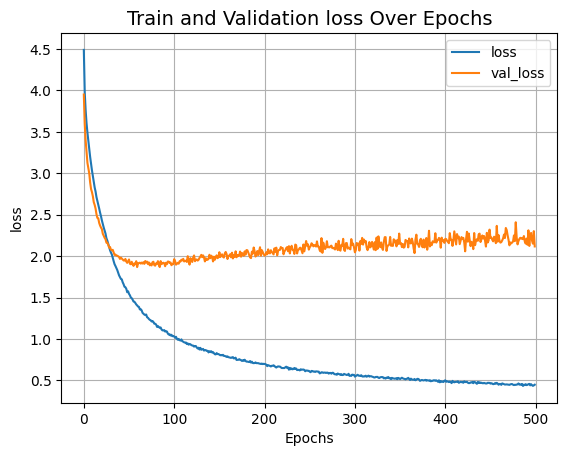

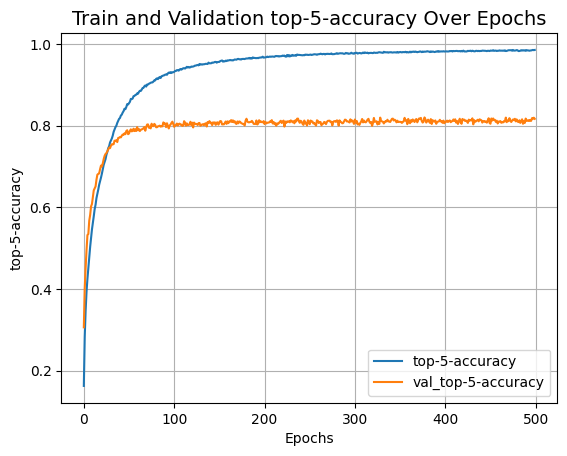

In [10]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=256)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")
